In [602]:
%reload_ext autoreload
%autoreload 2
import pynwb
import os

#DataJoint and DataJoint schema
import datajoint as dj
import numpy as np
import pandas as pd

## We also import a bunch of tables so that we can call them easily

from spyglass.common import (RawPosition, HeadDir, Speed, LinPos, StateScriptFile, VideoFile,
                                  DataAcquisitionDevice, CameraDevice, Probe,
                                  DIOEvents,
                                  ElectrodeGroup, Electrode, Raw, SampleCount,
                                  LFPSelection, LFP, LFPBandSelection, LFPBand,
                                  FirFilter,
                                  IntervalList,
                                  Lab, LabMember, LabTeam, Institution,
                                  BrainRegion,
                                  SensorData,
                                  Session, ExperimenterList,
                                  Subject,
                                  Task, TaskEpoch,
                                  Nwbfile, AnalysisNwbfile, NwbfileKachery, AnalysisNwbfileKachery,
                                  get_electrode_indices)
from spyglass.common.common_position import (PositionInfoParameters,IntervalPositionInfo)
from spyglass.common.common_interval import interval_list_intersect



from plot_lfp import (get_x_y_list, get_speed,get_speed_timestamp, get_timestamps_and_data,get_electrode_ids,remove_dead_tet_chans,check_for_dead_probes,
                      checking_other_dead_tets,simple_plot,plot_overlay,plot_overlay_with_pos,plot_speed_versus_theta, find_overlapping_times,get_x_y_timestamp_list)

import re
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter('ignore', category=DeprecationWarning)
warnings.simplefilter('ignore', category=ResourceWarning)

from spectral_connectivity import Multitaper
from spectral_connectivity import Connectivity
from spectral_connectivity import multitaper_connectivity

In [603]:
nwb_file_name = 'senor20201030_.nwb'

In [604]:
filename = r'/home/emonroe/Downloads/senor20201030_-Copy1.nwb_TrialsInfoByEpoch.ByTrial.csv'
trial_times = pd.read_csv(filename)
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf4,p_rew_leaf5,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,20,20,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,20,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [605]:
trial_times['stem_switch'] = trial_times['stem'].ne(trial_times['stem'].shift())

In [606]:
trial_data=[]
trial_data.append('NaN')
for ix in range(len(trial_times)-1):
    trial_start = trial_times.iloc[ix].poke_out_ts
    trial_end = trial_times.iloc[ix+1].poke_in_ts
    trial_data.append(trial_end-trial_start)
trial_times['trial_len'] = trial_data

In [607]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,p_rew_leaf6,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.156
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.84
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.226
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.727
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.73
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.67
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.462
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.298


In [608]:
obj = ['epoch','stem']
# trial_times['rew_rate'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.rolling(10, 1).mean())
# trial_times['rew_rate_ewm'] =trial_times.groupby(obj)[['reward']].transform(lambda x: x.ewm(10, 1).mean())
trial_times['rew_rate_ewm'] =trial_times.groupby(obj)[['reward']].apply(lambda x: x.ewm(halflife=5).mean())

In [609]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,decay_percent,p_rew_reset_leaf1,p_rew_reset_leaf2,p_rew_reset_leaf3,p_rew_reset_leaf4,p_rew_reset_leaf5,p_rew_reset_leaf6,stem_switch,trial_len,rew_rate_ewm
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,0.000000
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.156,0.000000
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,4.84,0.000000
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.226,0.534602
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,3.727,0.711667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,NaN,NaN,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.73,0.343740
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.67,0.428728
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.462,0.502706
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2.298,0.567102


In [611]:
for ix in range(1,7):
    trial_times[f'rew_rate_{ix}'] = (trial_times[trial_times['leaf']==ix].rew_rate_ewm)
trial_times = trial_times.ffill()

In [612]:
better_leaf=[]
for ix in range(len(trial_times)):
    if trial_times.loc[ix,'stem']=='A':
        if trial_times.loc[ix,'rew_rate_1'] >trial_times.loc[ix,'rew_rate_2']:
            better_leaf.append(1) 
        else:
            better_leaf.append(2) 
    if trial_times.loc[ix,'stem']=='B':
        if trial_times.loc[ix,'rew_rate_3'] >trial_times.loc[ix,'rew_rate_4']:
            better_leaf.append(3) 
        else:
            better_leaf.append(4) 
    if trial_times.loc[ix,'stem']=='C':
        if trial_times.loc[ix,'rew_rate_5'] >trial_times.loc[ix,'rew_rate_6']:
            better_leaf.append(5) 
        else:
            better_leaf.append(6) 

            

In [613]:
trial_times['better_leaf']=better_leaf

In [614]:
trial_times

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,stem_switch,trial_len,rew_rate_ewm,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,NaN,0.000000,NaN,NaN,NaN,0.00000,NaN,NaN,4
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,False,2.156,0.000000,NaN,NaN,0.000000,0.00000,NaN,NaN,4
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,True,4.84,0.000000,NaN,0.000000,0.000000,0.00000,NaN,NaN,2
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,2.226,0.534602,0.534602,0.000000,0.000000,0.00000,NaN,NaN,1
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,False,3.727,0.711667,0.534602,0.711667,0.000000,0.00000,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.73,0.343740,0.343740,0.394882,0.242222,0.21082,0.394497,0.472881,2
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.67,0.428728,0.343740,0.428728,0.242222,0.21082,0.394497,0.472881,2
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.462,0.502706,0.502706,0.428728,0.242222,0.21082,0.394497,0.472881,1
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,False,2.298,0.567102,0.502706,0.567102,0.242222,0.21082,0.394497,0.472881,2


In [615]:
going_tow_better=[]
for ix in range(len(trial_times)):
    if trial_times.loc[ix,'leaf'] == trial_times.loc[ix,'better_leaf']:
        going_tow_better.append(1)
    else:
        going_tow_better.append(0)  
trial_times['going_tow_better']= going_tow_better

In [616]:
trial_times[0:20]

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better
0,senor20201030_.nwb,2,0,4,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,NaN,NaN,NaN,0.0,NaN,NaN,4,1
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,NaN,NaN,0.0,0.0,NaN,NaN,4,0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,NaN,0.000000,0.0,0.0,NaN,NaN,2,1
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,0.534602,0.534602,0.000000,0.0,0.0,NaN,NaN,1,1
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.711667,0.534602,0.711667,0.0,0.0,NaN,NaN,2,1
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.227,0.799355,0.799355,0.711667,0.0,0.0,NaN,NaN,1,1
6,senor20201030_.nwb,2,6,2,A,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.135,0.592403,0.799355,0.592403,0.0,0.0,NaN,NaN,1,0
7,senor20201030_.nwb,2,7,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.25,0.685835,0.685835,0.592403,0.0,0.0,NaN,NaN,1,1
8,senor20201030_.nwb,2,8,4,B,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,4.65,0.000000,0.685835,0.592403,0.0,0.0,NaN,NaN,4,1
9,senor20201030_.nwb,2,9,3,B,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.945,0.000000,0.685835,0.592403,0.0,0.0,NaN,NaN,4,0


In [617]:
trial_times = trial_times.drop(trial_times[trial_times.trial_number_by_epoch==0].index)

In [115]:
# running_tow_better_speed=[]
# running_tow_better_speed.append(trial_times[trial_times['going_tow_better']==1].trial_len)
# running_tow_better_speed=running_tow_better_speed[0]
# running_tow_worse_speed=[]
# running_tow_worse_speed.append(trial_times[trial_times['going_tow_better']==0].trial_len)
# running_tow_worse_speed=running_tow_worse_speed[0]



In [618]:
# trial_times_e2 = trial_times[trial_times.epoch==2]
# trial_times_e2_stay = trial_times_e2[trial_times_e2.stem_switch==False]


# running_tow_better_speed=[]
# running_tow_better_speed.append(trial_times_e2 [trial_times_e2['going_tow_better']==1].trial_len)
# running_tow_better_speed=running_tow_better_speed[0]
# del running_tow_better_speed[0]
# running_tow_worse_speed=[]
# running_tow_worse_speed.append(trial_times_e2 [trial_times_e2 ['going_tow_better']==0].trial_len)
# running_tow_worse_speed=running_tow_worse_speed[0]

trial_times_stay = trial_times[trial_times.stem_switch==False]

running_tow_better_speed=[]
running_tow_better_speed.append(trial_times_stay[trial_times_stay['going_tow_better']==1].trial_len)
running_tow_better_speed=running_tow_better_speed[0]
# del running_tow_better_speed[0]
running_tow_worse_speed=[]
running_tow_worse_speed.append(trial_times_stay[trial_times_stay['going_tow_better']==0].trial_len)
running_tow_worse_speed=running_tow_worse_speed[0]

In [619]:
running_tow_better_speed

3       2.226
4       3.727
5       2.227
7        2.25
11      2.645
        ...  
1251    2.886
1253    2.843
1256     2.67
1257    2.462
1258    2.298
Name: trial_len, Length: 539, dtype: object

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2.156,0.000000,NaN,NaN,0.0,0.0,NaN,NaN,4,0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4.84,0.000000,NaN,0.000000,0.0,0.0,NaN,NaN,2,1
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.226,0.500000,0.50,0.000000,0.0,0.0,NaN,NaN,1,1
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,3.727,0.666667,0.50,0.666667,0.0,0.0,NaN,NaN,2,1
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2.227,0.750000,0.75,0.666667,0.0,0.0,NaN,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255,senor20201030_.nwb,14,175,1,A,0,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.73,0.400000,0.40,0.400000,0.0,0.0,0.4,0.6,2,0
1256,senor20201030_.nwb,14,176,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.67,0.400000,0.40,0.400000,0.0,0.0,0.4,0.6,2,1
1257,senor20201030_.nwb,14,177,1,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.462,0.600000,0.60,0.400000,0.0,0.0,0.4,0.6,1,1
1258,senor20201030_.nwb,14,178,2,A,1,1.604104e+09,1.604104e+09,1.604104e+09,1.604104e+09,...,2.298,0.600000,0.60,0.600000,0.0,0.0,0.4,0.6,2,1


In [620]:
trial_times[178:182]

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,trial_len,rew_rate_ewm,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better
179,senor20201030_.nwb,2,179,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,2.401,0.603506,0.248203,0.216053,0.361860,0.315015,0.693296,0.603506,5,0
181,senor20201030_.nwb,4,1,3,B,0,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,2.32,0.465398,0.248203,0.216053,0.465398,1.000000,0.693296,0.603506,4,0
182,senor20201030_.nwb,4,2,1,A,1,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,3.345,1.000000,1.000000,0.216053,0.465398,1.000000,0.693296,0.603506,1,1
183,senor20201030_.nwb,4,3,2,A,0,1.604083e+09,1.604083e+09,1.604083e+09,1.604083e+09,...,1.931,0.465398,1.000000,0.465398,0.465398,1.000000,0.693296,0.603506,1,0


In [621]:
trial_times[trial_times.trial_number_by_epoch==0].index

Int64Index([], dtype='int64')

Text(0.5, 1.0, 'histrogram of trial lengths while running towards better vs worse leaf stay trials, whole day')

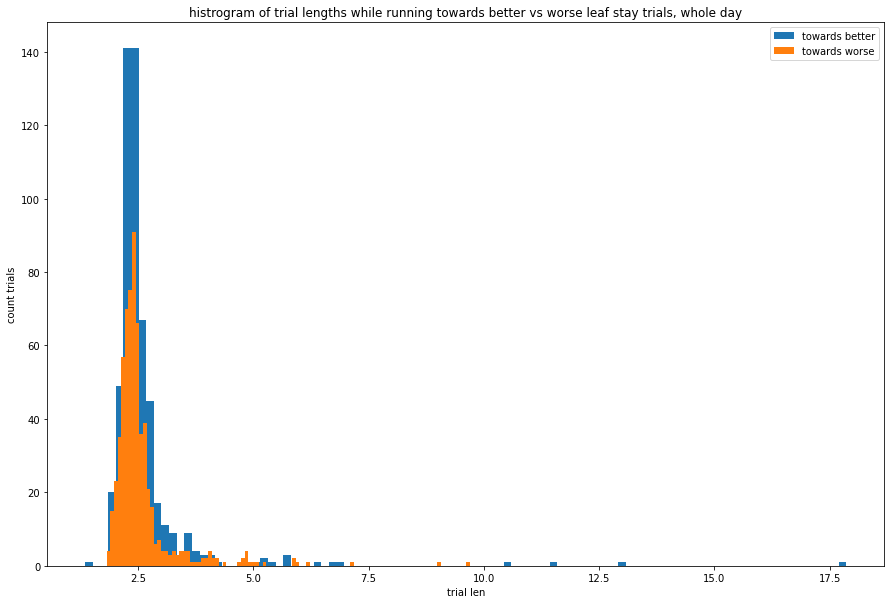

In [622]:
plt.figure(figsize=(15,10))
plt.hist(running_tow_better_speed,bins=100,label='towards better')
plt.hist(running_tow_worse_speed,bins=100,label='towards worse')
plt.legend()

plt.xlabel('trial len')
plt.ylabel('count trials')
plt.title('histrogram of trial lengths while running towards better vs worse leaf stay trials, whole day')

In [623]:
print(len(running_tow_better_speed),len(running_tow_worse_speed))

539 625


Text(0.5, 1.0, 'run lengths towards better vs worse leaf-only stay trials')

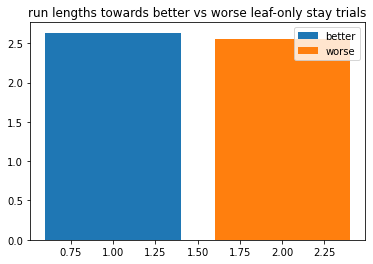

In [624]:
import statistics
plt.bar(1,statistics.mean(running_tow_better_speed),label='better')

plt.bar(2,statistics.mean(running_tow_worse_speed),label='worse')
plt.legend()
plt.title('run lengths towards better vs worse leaf-only stay trials')

In [625]:
statistics.mean(running_tow_better_speed)

2.6337254144707503

In [626]:
statistics.mean(running_tow_worse_speed)

2.5571184005737306

Text(0, 0.5, 'length of trial (s)')

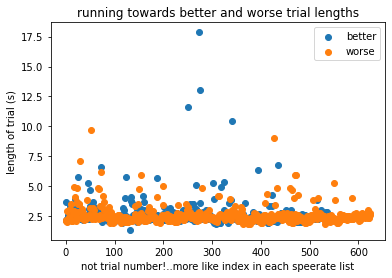

In [627]:
plt.scatter(range(len(running_tow_better_speed)),running_tow_better_speed,label='better')
plt.scatter(range(len(running_tow_worse_speed)),running_tow_worse_speed,label='worse')
plt.legend()
plt.title('running towards better and worse trial lengths')
plt.xlabel('not trial number!..more like index in each speerate list')
plt.ylabel('length of trial (s)')

In [628]:
position_info = (IntervalPositionInfo() &
                 {'nwb_file_name': nwb_file_name,
                  'interval_list_name': 'pos 1 valid times',
                  'position_info_param_name': 'default'}
                ).fetch1_dataframe()
position_info

,head_position_x,head_position_y,head_orientation,head_velocity_x,head_velocity_y,head_speed
time,,,,,,
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
1.604078e+09,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1.604079e+09,96.2465,68.4265,1.892547,-18.510226,39.833951,43.924618
1.604079e+09,96.1395,70.3525,1.783228,-13.011806,39.301131,41.399107
1.604079e+09,96.1930,72.3320,1.723446,-8.684986,37.011240,38.016587


In [629]:
trial_timestamps =[]
for ix in range(len(trial_times)-1):
    trial_start = trial_times.iloc[ix].poke_out_ts
    trial_end = trial_times.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])

In [630]:
#i want to mask the position df by these timestamps
#then find average speed
#then add it to original df?

In [631]:
#could just start by masking original df to only 1st run to not have to deal with different lengths 

In [632]:

e2 = trial_times[trial_times['epoch']==2]

trial_timestamps =[]
for ix in range(len(e2)-1):
    trial_start = e2.iloc[ix].poke_out_ts
    trial_end = e2.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])
    


In [633]:
avg_speed_per_trial=[]
avg_speed_per_trial.append('NaN')
for ix in range(len(trial_timestamps)):
    speed_x,speed_y = get_speed_timestamp(trial_timestamps[ix][0],trial_timestamps[ix][1],position_info)
    avg_speed_per_trial.append(statistics.mean(speed_y))


Text(0.5, 1.0, 'average speed per trial run')

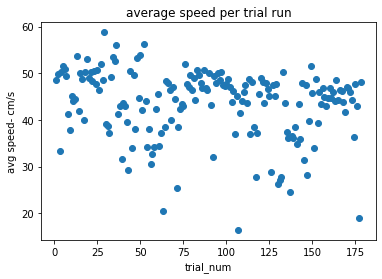

In [634]:
plt.scatter(range(1,len(avg_speed_per_trial)),avg_speed_per_trial[1:])
plt.xlabel('trial_num')
plt.ylabel('avg speed- cm/s')
plt.title('average speed per trial run')

In [635]:
e2['avg_speed']=avg_speed_per_trial

In [636]:
running_tow_worse_speed.append(e2[e2['going_tow_better']==0].avg_speed)



1          2.156
6          2.135
9          2.945
14         2.025
16         2.186
         ...    
168    46.139883
169    43.741417
174    44.174123
175    36.396941
179    48.241862
Length: 722, dtype: object

In [637]:
running_tow_worse_speed



1       2.156
6       2.135
9       2.945
14      2.025
16      2.186
        ...  
1250    2.379
1252     2.49
1254    2.347
1255     2.73
1259    2.636
Name: trial_len, Length: 625, dtype: object

In [638]:
del running_tow_worse_speed[1]



Text(0.5, 1.0, 'average speed per trial only in e2')

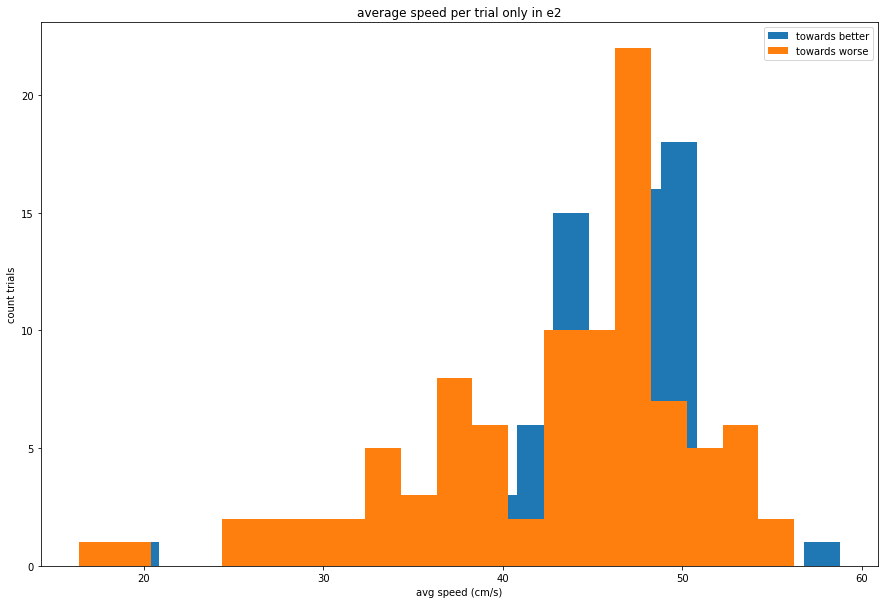

In [639]:
running_tow_better_speed=[]
running_tow_better_speed.append(e2[e2['going_tow_better']==1].avg_speed)
running_tow_better_speed=running_tow_better_speed[0]
running_tow_worse_speed=[]
running_tow_worse_speed.append(e2[e2['going_tow_better']==0].avg_speed)
running_tow_worse_speed = running_tow_worse_speed[0]
del running_tow_worse_speed[1]



plt.figure(figsize=(15,10))
plt.hist(running_tow_better_speed,bins=20,label='towards better')
plt.hist(running_tow_worse_speed,bins=20,label='towards worse')
plt.legend()

plt.xlabel('avg speed (cm/s)')
plt.ylabel('count trials')
plt.title('average speed per trial only in e2')

Text(0.5, 1.0, 'run lengths towards better vs worse leaf-only stay trials')

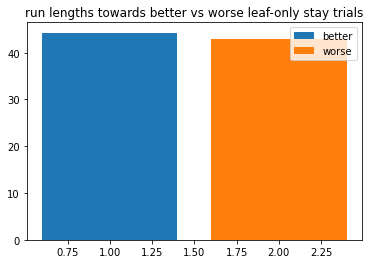

In [640]:
plt.bar(1,statistics.mean(running_tow_better_speed),label='better')

plt.bar(2,statistics.mean(running_tow_worse_speed),label='worse')
plt.legend()
plt.title('run lengths towards better vs worse leaf-only stay trials')

In [641]:
statistics.mean(running_tow_worse_speed)

42.8837047706578

In [642]:
statistics.mean(running_tow_better_speed)

44.273243986285905

In [287]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,avg_speed
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,NaN,NaN,0.0,0.0,NaN,NaN,4,0,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,NaN,0.000000,0.0,0.0,NaN,NaN,2,1,48.655067
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.500000,0.50,0.000000,0.0,0.0,NaN,NaN,1,1,49.832956
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.666667,0.50,0.666667,0.0,0.0,NaN,NaN,2,1,33.240799
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.750000,0.75,0.666667,0.0,0.0,NaN,NaN,1,1,50.213815
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.600000,0.30,0.300000,0.5,0.4,0.6,0.6,6,1,36.396941
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.600000,0.30,0.300000,0.5,0.4,0.6,0.6,6,0,47.783901
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.600000,0.30,0.300000,0.5,0.4,0.6,0.6,6,1,42.932353
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.700000,0.30,0.300000,0.5,0.4,0.7,0.6,5,1,18.862685


In [643]:
e2['bout_num'] = e2['stem'].ne(e2['stem'].shift()).cumsum()





In [644]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_1,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,avg_speed,bout_num
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,0.00000,0.000000,NaN,NaN,4,0,NaN,1
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.000000,0.00000,0.000000,NaN,NaN,2,1,48.655067,2
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.534602,0.000000,0.00000,0.000000,NaN,NaN,1,1,49.832956,2
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.534602,0.711667,0.00000,0.000000,NaN,NaN,2,1,33.240799,2
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.799355,0.711667,0.00000,0.000000,NaN,NaN,1,1,50.213815,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.248203,0.216053,0.36186,0.315015,0.614619,0.534989,5,0,36.396941,16
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.248203,0.216053,0.36186,0.315015,0.595229,0.534989,5,1,47.783901,16
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.248203,0.216053,0.36186,0.315015,0.595229,0.647660,6,1,42.932353,16
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.248203,0.216053,0.36186,0.315015,0.693296,0.647660,5,1,18.862685,16


In [645]:
e2.bout_num.max()


16

In [646]:
bout_len_lst=[]
for ix in range(1,(e2.bout_num.max()+1)):
    bout_len = len(e2[e2.bout_num == ix])
    bout_len_lst.append((np.ones(bout_len)*bout_len).tolist())
bout_len_list = [item for sublist in bout_len_lst for item in sublist]

e2['bout_lens_per_bout']=bout_len_list

In [647]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,avg_speed,bout_num,bout_lens_per_bout
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.00000,0.000000,NaN,NaN,4,0,NaN,1,1.0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.00000,0.000000,NaN,NaN,2,1,48.655067,2,6.0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.000000,0.00000,0.000000,NaN,NaN,1,1,49.832956,2,6.0
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.711667,0.00000,0.000000,NaN,NaN,2,1,33.240799,2,6.0
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.711667,0.00000,0.000000,NaN,NaN,1,1,50.213815,2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.614619,0.534989,5,0,36.396941,16,30.0
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.534989,5,1,47.783901,16,30.0
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.647660,6,1,42.932353,16,30.0
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.693296,0.647660,5,1,18.862685,16,30.0


In [648]:
long_bouts = e2[e2.bout_lens_per_bout>15]

In [649]:
long_bouts

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,avg_speed,bout_num,bout_lens_per_bout
13,senor20201030_.nwb,2,13,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.592403,0.00000,0.000000,0.711667,0.534602,1,1,44.550004,5,17.0
14,senor20201030_.nwb,2,14,2,A,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.606182,0.00000,0.000000,0.711667,0.534602,1,0,53.736003,5,17.0
15,senor20201030_.nwb,2,15,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.606182,0.00000,0.000000,0.711667,0.534602,1,1,41.895874,5,17.0
16,senor20201030_.nwb,2,16,2,A,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.560729,0.00000,0.000000,0.711667,0.534602,1,0,50.007276,5,17.0
17,senor20201030_.nwb,2,17,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.560729,0.00000,0.000000,0.711667,0.534602,1,1,48.844173,5,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.614619,0.534989,5,0,36.396941,16,30.0
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.534989,5,1,47.783901,16,30.0
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.647660,6,1,42.932353,16,30.0
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.693296,0.647660,5,1,18.862685,16,30.0


Text(0, 0.5, 'speed cm/s')

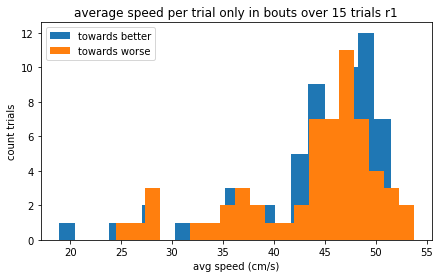

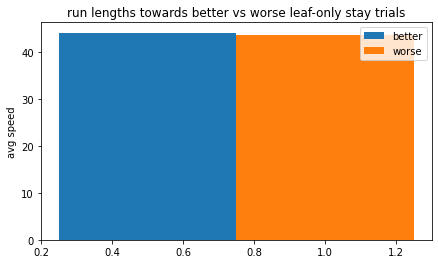

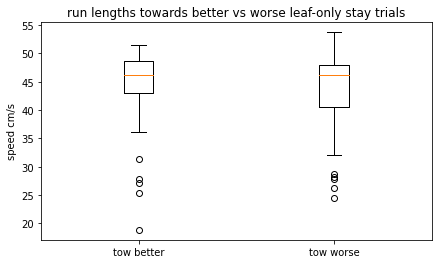

In [650]:
running_tow_better_speed=[]
running_tow_better_speed.append(long_bouts[long_bouts['going_tow_better']==1].avg_speed)
running_tow_better_speed=running_tow_better_speed[0]
running_tow_worse_speed=[]
running_tow_worse_speed.append(long_bouts[long_bouts['going_tow_better']==0].avg_speed)
running_tow_worse_speed = running_tow_worse_speed[0]



plt.figure(figsize=(7,4))
plt.hist(running_tow_better_speed,bins=20,label='towards better')
plt.hist(running_tow_worse_speed,bins=20,label='towards worse')
plt.legend()
plt.xlabel('avg speed (cm/s)')
plt.ylabel('count trials')
plt.title('average speed per trial only in bouts over 15 trials r1')

plt.figure(figsize=(7,4))
plt.bar(.5,statistics.mean(running_tow_better_speed),label='better',width=.5)
plt.bar(1,statistics.mean(running_tow_worse_speed),label='worse',width=.5)
plt.legend()
plt.title('run speeds towards better vs worse leaf-only stay trials')
plt.ylabel('avg speed')


plt.figure(figsize=(7,4))
plt.boxplot([running_tow_better_speed,running_tow_worse_speed])
plt.title('run speeds towards better vs worse leaf-only stay trials')
plt.xticks([1, 2], ['tow better','tow worse'])
plt.ylabel('speed cm/s')

In [651]:
print(statistics.mean(running_tow_better_speed))
print(statistics.mean(running_tow_worse_speed))

44.1817993928864
43.67370645946034


In [348]:
#could do this by epoch!
#could also do this by nom prob, what if there was a difference? 

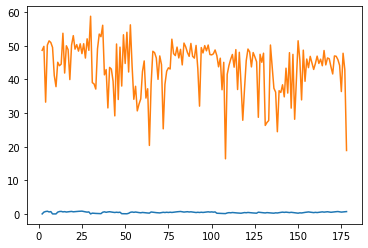

In [653]:
plt.plot(e2.rew_rate_ewm[1:-1])#,e2.avg_speed)
plt.plot(e2.avg_speed[1:-1])

Text(0, 0.5, 'recent reward rate at leaf')

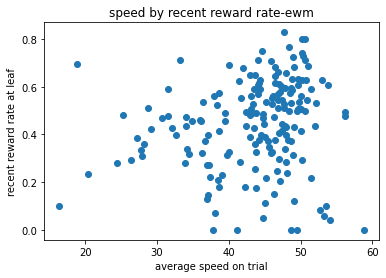

In [694]:
plt.scatter(e2.avg_speed[1:-1],e2.rew_rate_ewm[1:-1])
plt.title('speed by recent reward rate-ewm')
plt.xlabel('average speed on trial')
plt.ylabel('recent reward rate at leaf')

#put. aline on here! do a few versions
#max speed, median. 
#maybe a speed threshold. only while the rat is running or something. a second b4 or after choice point. Trim off the beginning! at least. 
#look at raw rata a little more. speed profile voer time fore very trial. 
#raster, but sort by value of port 
#where is it where the animal is going faster? Whats driving it? 
#5,10,20 for window sizes. (how long on avg does he spend at stem before switch.. the last 3 trials? (if he only spends 3 stems 

#maybe global - can be both of those things. 

Text(0, 0.5, 'recent reward rate')

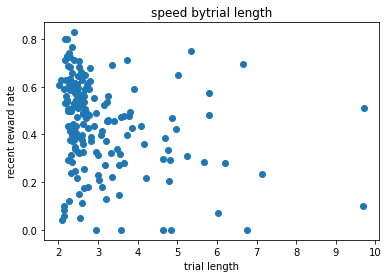

In [695]:
plt.scatter(e2.trial_len[1:-1],e2.rew_rate_ewm[1:-1])
plt.title('speed bytrial length')
plt.xlabel('trial length')
plt.ylabel('recent reward rate')

Text(0.5, 0, 'recent reward rate')

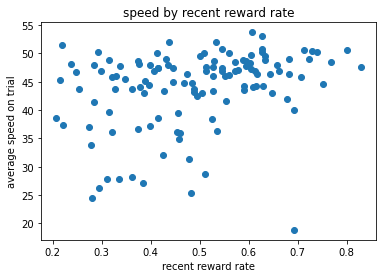

In [656]:
plt.scatter(long_bouts.rew_rate_ewm,long_bouts.avg_speed)
plt.title('speed by recent reward rate')
plt.ylabel('average speed on trial')
plt.xlabel('recent reward rate')

AttributeError: 'DataFrame' object has no attribute 'rew_rate'

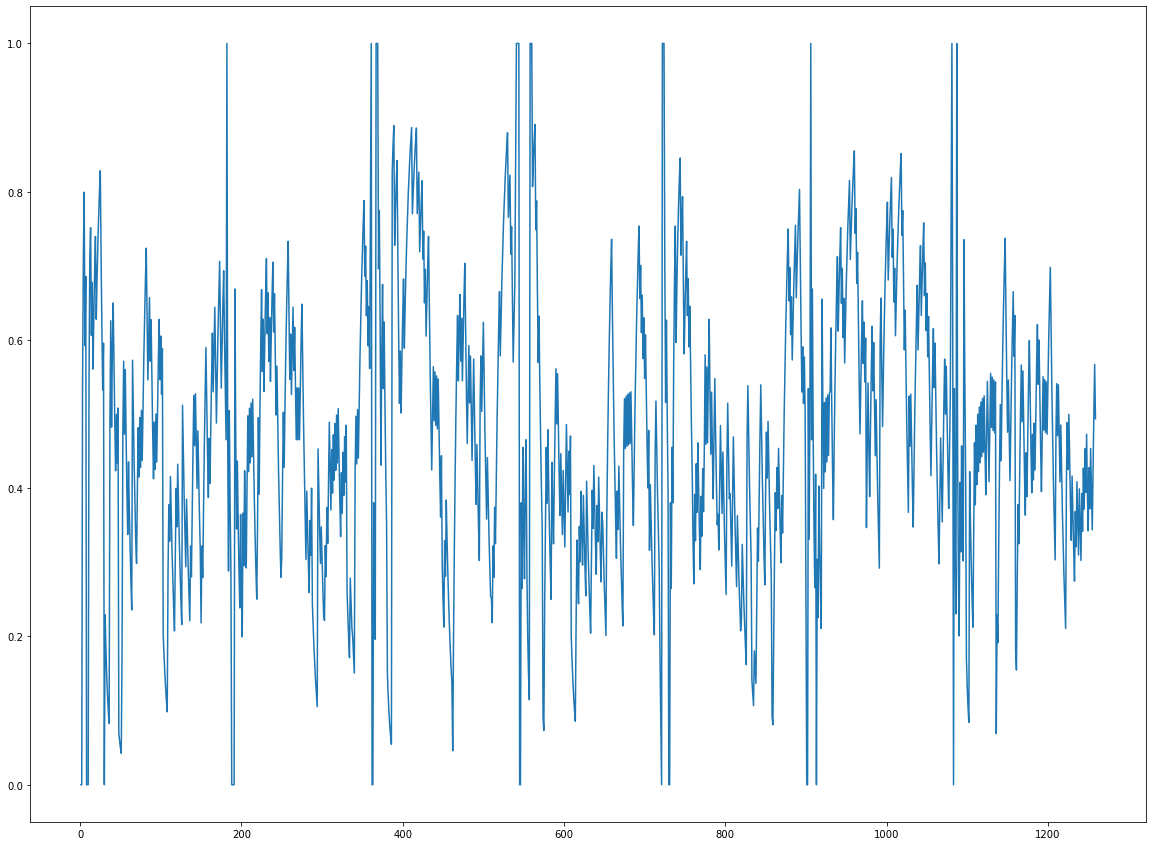

In [657]:
plt.figure(figsize=(20,15))
plt.plot(trial_times.rew_rate_ewm)
plt.plot(trial_times.rew_rate)

trial_times

Text(0.5, 1.0, 'rew rate x avg speed on trial')

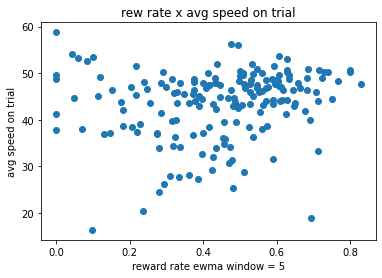

In [693]:
plt.scatter(e2.rew_rate_ewm[1:], e2.avg_speed[1:])
plt.xlabel('reward rate ewma window = 5')
plt.ylabel('avg speed on trial')
plt.title('rew rate x avg speed on trial')


Text(0.5, 1.0, 'rew rate from previously visiting stem vs avg speed from trial')

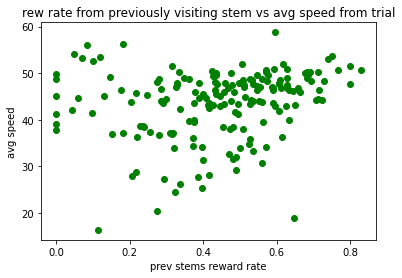

In [691]:
for ix in range(1,len(e2)):
    speed_trial =  e2.iloc[ix].avg_speed
    prev_rew_history = e2.iloc[ix-1].rew_rate_ewm
    plt.scatter(prev_rew_history,speed_trial,color='g')
    plt.xlabel('prev stems reward rate')
    plt.ylabel('avg speed')
plt.title('rew rate from previously visiting stem vs avg speed from trial')
#plot for previously rewarded trial vs not. 
#quite impacted by the beginning of the trial; if hes licking! speed threshold! 
#raw speed profiles. 
#were oversampling 

In [438]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,rew_rate_ewm,avg_speed,delta1_2,delta3_4,delta5_6
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,4,0,0.000000,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,NaN,NaN,2,1,0.000000,48.655067,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,1,1,0.517322,49.832956,0.517322,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,2,1,0.689486,33.240799,0.172165,NaN,NaN
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,NaN,NaN,NaN,1,1,0.775362,50.213815,0.085876,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.367513,0.563958,0.525057,6,1,0.525057,36.396941,0.021661,0.026585,0.038901
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.367513,0.557752,0.525057,6,0,0.557752,47.783901,0.021661,0.026585,0.032695
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.367513,0.557752,0.588139,6,1,0.588139,42.932353,0.021661,0.026585,0.030387
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.367513,0.616390,0.588139,5,1,0.616390,18.862685,0.021661,0.026585,0.028250


In [660]:
for ix in range (1,7):
    e2[f'rew_rate_{ix}'] = e2[e2.leaf==ix].rew_rate_ewm
    e2[f'rew_rate_{ix}'] = e2[f'rew_rate_{ix}'].ffill()

e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,rew_rate_2,rew_rate_3,rew_rate_4,rew_rate_5,rew_rate_6,better_leaf,going_tow_better,avg_speed,bout_num,bout_lens_per_bout
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,NaN,0.00000,NaN,NaN,NaN,4,0,NaN,1,1.0
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0.000000,0.00000,NaN,NaN,NaN,2,1,48.655067,2,6.0
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.000000,0.00000,NaN,NaN,NaN,1,1,49.832956,2,6.0
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.711667,0.00000,NaN,NaN,NaN,2,1,33.240799,2,6.0
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,0.711667,0.00000,NaN,NaN,NaN,1,1,50.213815,2,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.614619,0.534989,5,0,36.396941,16,30.0
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.534989,5,1,47.783901,16,30.0
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.595229,0.647660,6,1,42.932353,16,30.0
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0.216053,0.36186,0.315015,0.693296,0.647660,5,1,18.862685,16,30.0


In [661]:

# e2['delta3_4'] = abs(e2['rew_rate_3']-e2['rew_rate_4']e2e2['delta1_2'] = abs(e2['rew_rate_1']-e2['rew_rate_2'])
# ['delta1_2'] = abs(e2['rew_rate_1']-e2['rew_rate_2'])

# )
# e2['delta5_6'] = abs(e2['rew_rate_5']-e2['rew_rate_6'])

# for ix in range (1,7):
#     e2[f'rew_rate_{ix}'] = e2[e2.leaf==ix].rew_rate_ewm



e2['delta1_2'] = (e2['rew_rate_1']-e2['rew_rate_2'])
e2['delta2_1'] = (e2['rew_rate_2']-e2['rew_rate_1'])
e2['delta3_4'] = (e2['rew_rate_3']-e2['rew_rate_4'])
e2['delta4_3'] = (e2['rew_rate_4']-e2['rew_rate_3'])
e2['delta5_6'] = (e2['rew_rate_5']-e2['rew_rate_6'])
e2['delta6_5'] = (e2['rew_rate_6']-e2['rew_rate_5'])




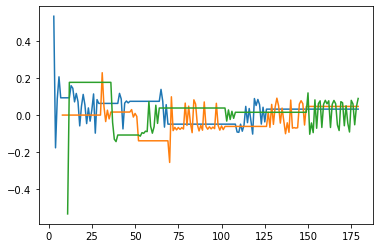

In [662]:
plt.plot(e2['delta1_2'])
# plt.plot(e2['delta2_1'])

plt.plot(e2['delta3_4'])
plt.plot(e2['delta5_6'])



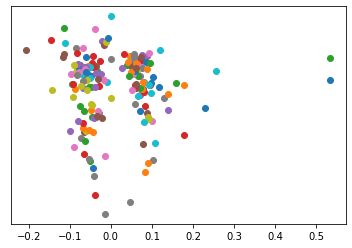

In [663]:
for ix in range(len(e2)):
    if e2.iloc[ix].leaf ==1:
        plt.scatter(e2.iloc[ix]['delta1_2'], e2.iloc[ix]['avg_speed'])
    if e2.iloc[ix].leaf ==2:
        plt.scatter(e2.iloc[ix]['delta2_1'], e2.iloc[ix]['avg_speed'])
    if e2.iloc[ix].leaf ==3:
        plt.scatter(e2.iloc[ix]['delta3_4'], e2.iloc[ix]['avg_speed'])
    if e2.iloc[ix].leaf ==4:
        plt.scatter(e2.iloc[ix]['delta4_3'], e2.iloc[ix]['avg_speed'])
    if e2.iloc[ix].leaf ==5:
        plt.scatter(e2.iloc[ix]['delta5_6'], e2.iloc[ix]['avg_speed'])
    if e2.iloc[ix].leaf ==6:
        plt.scatter(e2.iloc[ix]['delta6_5'], e2.iloc[ix]['avg_speed'])
# plt.xlim(-.2,.3)


In [449]:
e2['avg_speed']

1            NaN
2      48.655067
3      49.832956
4      33.240799
5      50.213815
         ...    
175    36.396941
176    47.783901
177    42.932353
178    18.862685
179    48.241862
Name: avg_speed, Length: 179, dtype: object

In [433]:
e2.rew_rate_4 = e2.rew_rate_4.ffill()

In [424]:
e2[e2.stem==1].rew_rate_ewm

Series([], Name: rew_rate_ewm, dtype: float64)

In [454]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,better_leaf,going_tow_better,rew_rate_ewm,avg_speed,delta1_2,delta3_4,delta5_6,delta2_1,delta4_3,delta6_5
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2,1,0.000000,48.655067,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,1,0.517322,49.832956,0.517322,NaN,NaN,-0.517322,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2,1,0.689486,33.240799,-0.172165,NaN,NaN,0.172165,NaN,NaN
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,1,0.775362,50.213815,0.085876,NaN,NaN,-0.085876,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6,1,0.525057,36.396941,0.021661,0.026585,0.038901,-0.021661,-0.026585,-0.038901
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6,0,0.557752,47.783901,0.021661,0.026585,0.032695,-0.021661,-0.026585,-0.032695
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,6,1,0.588139,42.932353,0.021661,0.026585,-0.030387,-0.021661,-0.026585,0.030387
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,5,1,0.616390,18.862685,0.021661,0.026585,0.028250,-0.021661,-0.026585,-0.028250


Text(0.5, 1.0, '[20, 50, 50, 80, 20, 20]')

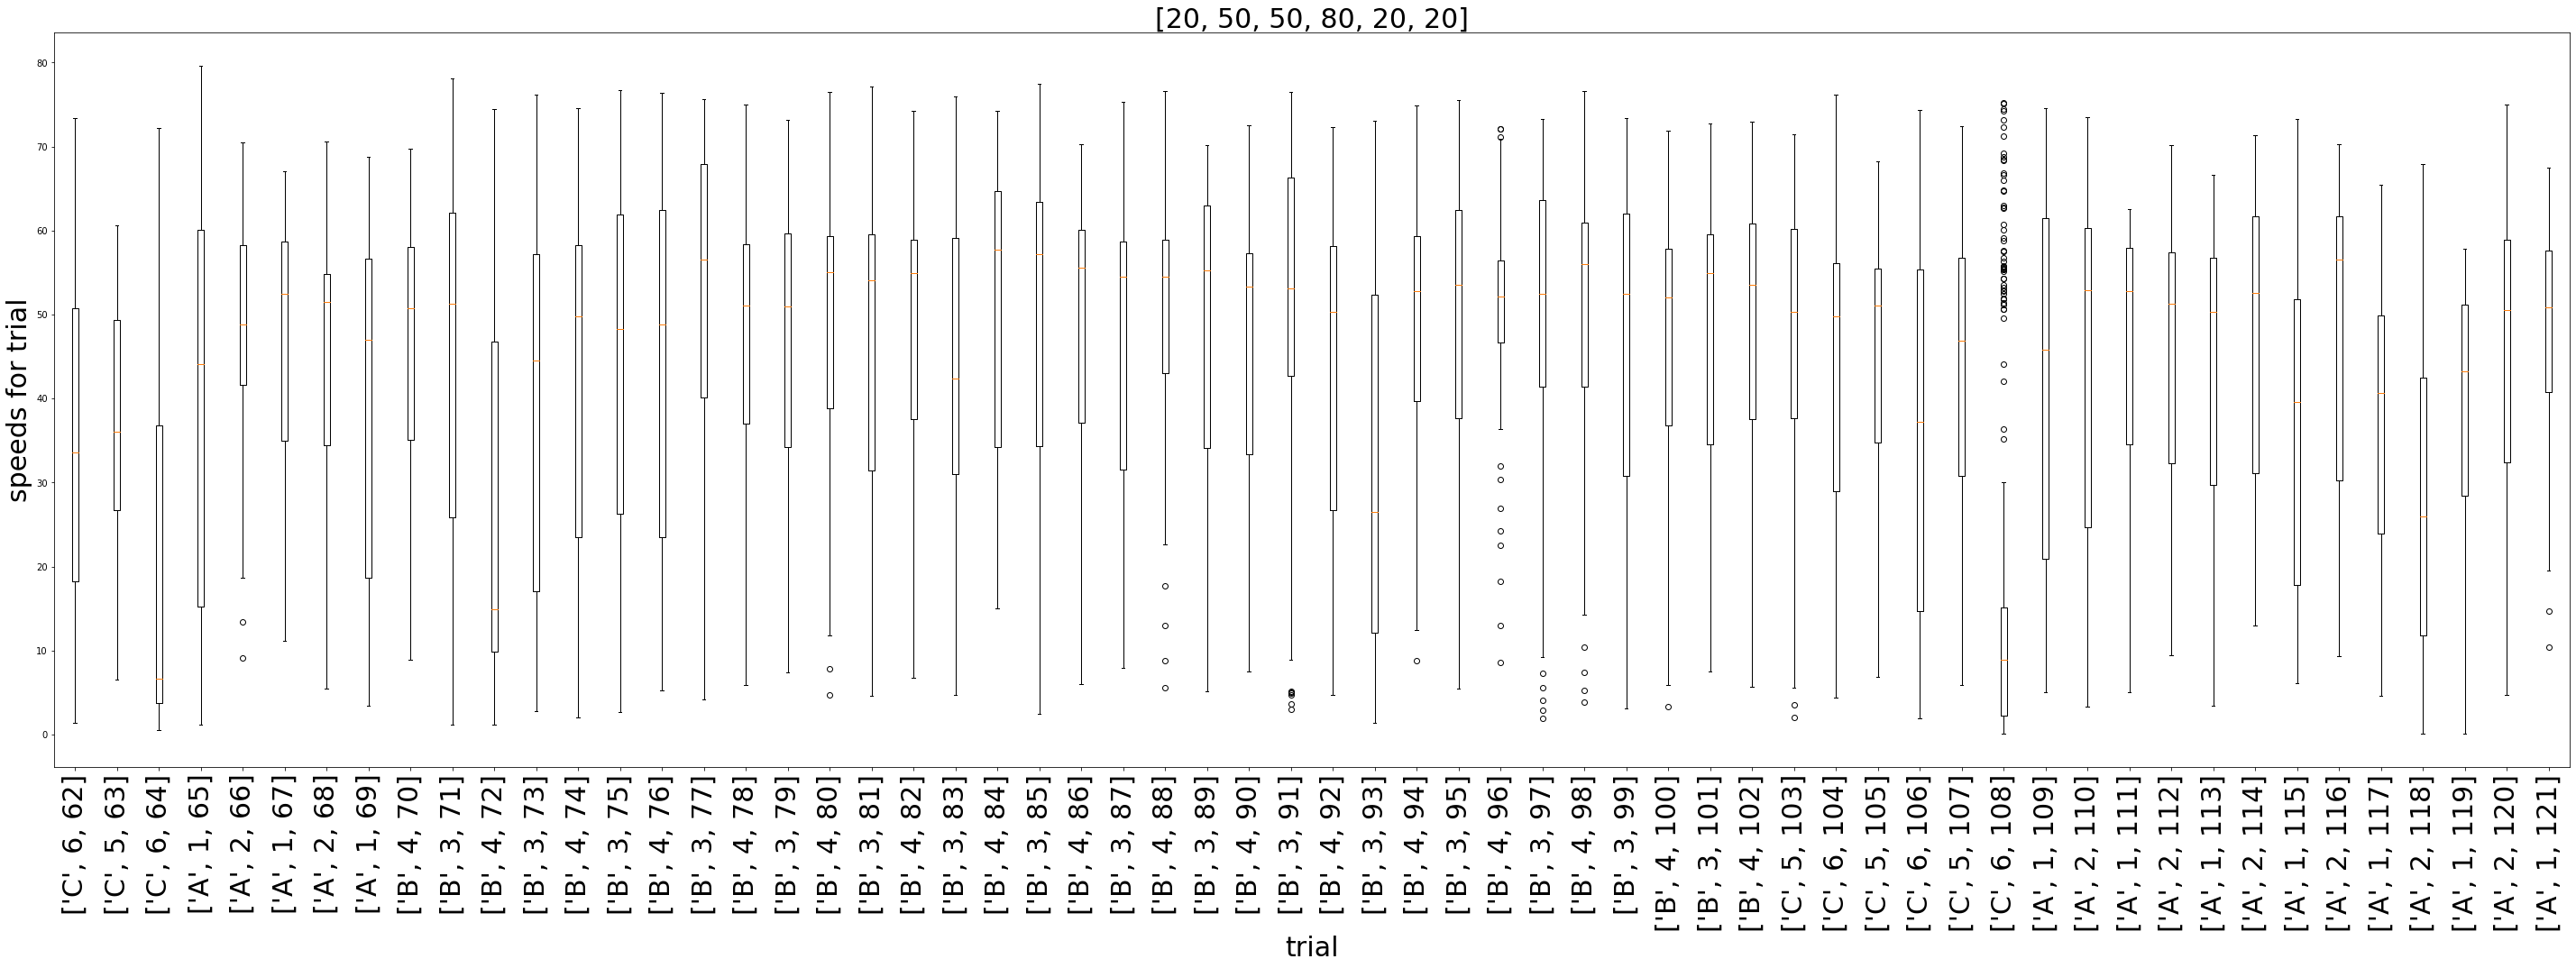

In [664]:

trial_timestamps =[]
for ix in range(len(e2)-1):
    trial_start = e2.iloc[ix].poke_out_ts
    trial_end = e2.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])
plt.figure(figsize=(50,15))

for ix in range(60,120):
    speed_x,speed_y = get_speed_timestamp(trial_timestamps[ix][0],trial_timestamps[ix][1],position_info)
    plt.boxplot(speed_y,positions=[ix])
xtickNames = plt.xticks(range(60,120),stem_leaf,rotation=90,fontsize=30)
plt.ylabel('speeds for trial',fontsize=30)
plt.xlabel('trial',fontsize=30)
plt.title(f'{probs}',fontsize=30)
# plt.setp(xtickNames, rotation=45, fontsize=8)




In [665]:
trial = 60
probs = [e2.iloc[trial].p_rew_leaf1,e2.iloc[trial].p_rew_leaf2,e2.iloc[trial].p_rew_leaf3,e2.iloc[trial].p_rew_leaf4,e2.iloc[trial].p_rew_leaf5,e2.iloc[trial].p_rew_leaf6]


In [666]:
# stem=[]
# leaf=[]
stem_leaf=[]
for ix in range(60,120):
    stem_leaf.append([e2.iloc[ix+1]['stem'],e2.iloc[ix+1]['leaf'],e2.iloc[ix+1]['trial_number_by_epoch']])
    # leaf.append(e2.iloc[ix+1]['leaf'])

In [667]:
e2.iloc[ix+1]['stem']

'A'

In [668]:
trial_timestamps =[]
for ix in range(len(e2)-1):
    trial_start = e2.iloc[ix].poke_out_ts
    trial_end = e2.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])
# plt.figure(figsize=(50,15))
mean_speed=[]
max_speed=[]
min_speed=[]
for ix in range(len(trial_timestamps)):
    speed_x,speed_y = get_speed_timestamp(trial_timestamps[ix][0],trial_timestamps[ix][1],position_info)
    mean_speed.append(statistics.mean(speed_y))
    max_speed.append(speed_y.max())
    min_speed.append(speed_y.min())

In [669]:
stem_switch_trials = (e2[e2.stem_switch == True]).index
stem_switch_trials


Int64Index([2, 8, 10, 13, 30, 37, 41, 48, 53, 65, 70, 103, 109, 127, 150], dtype='int64')

In [670]:
for ix in range(len(stem_switch_trials)):
    print(e2.iloc[stem_switch_trials[ix]].stem)

A
B
C
A
B
C
A
B
C
A
B
C
A
B
C


In [567]:
e2[0:20]

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,better_leaf,going_tow_better,rew_rate_ewm,avg_speed,delta1_2,delta3_4,delta5_6,delta2_1,delta4_3,delta6_5
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,4,0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,2,1,0.000000,48.655067,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,1,0.517322,49.832956,0.517322,NaN,NaN,-0.517322,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,2,1,0.689486,33.240799,-0.172165,NaN,NaN,0.172165,NaN,NaN
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,1,0.775362,50.213815,0.085876,NaN,NaN,-0.085876,NaN,NaN
6,senor20201030_.nwb,2,6,2,A,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,0,0.598084,51.471524,0.177279,NaN,NaN,-0.177279,NaN,NaN
7,senor20201030_.nwb,2,7,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,1,0.677189,50.972723,0.079105,NaN,NaN,-0.079105,NaN,NaN
8,senor20201030_.nwb,2,8,4,B,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,4,1,0.000000,49.516307,0.079105,0.0,NaN,-0.079105,0.0,NaN
9,senor20201030_.nwb,2,9,3,B,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,4,0,0.000000,41.173311,0.079105,0.0,NaN,-0.079105,0.0,NaN
10,senor20201030_.nwb,2,10,5,C,0,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,6,0,0.000000,37.844128,0.079105,0.0,NaN,-0.079105,0.0,NaN


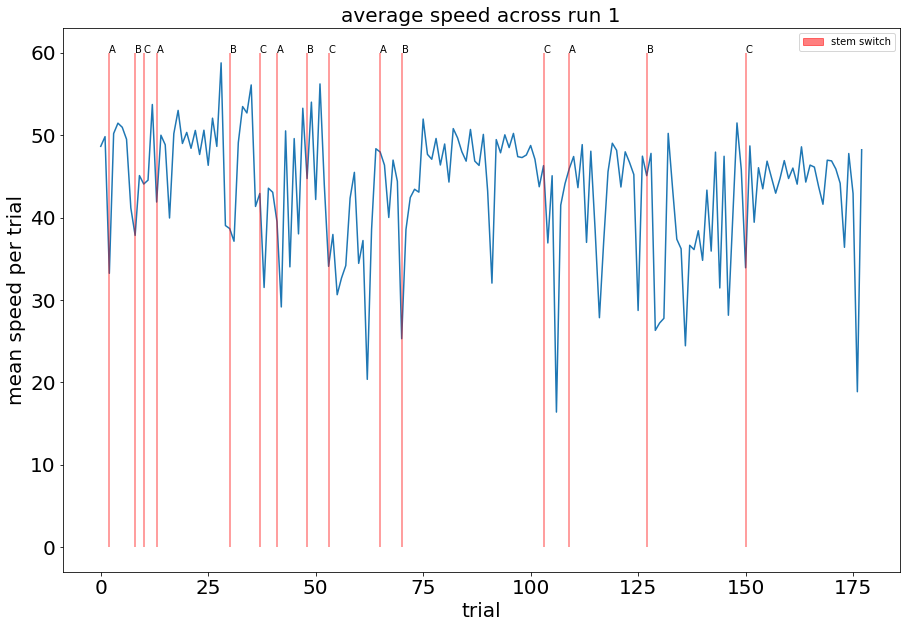

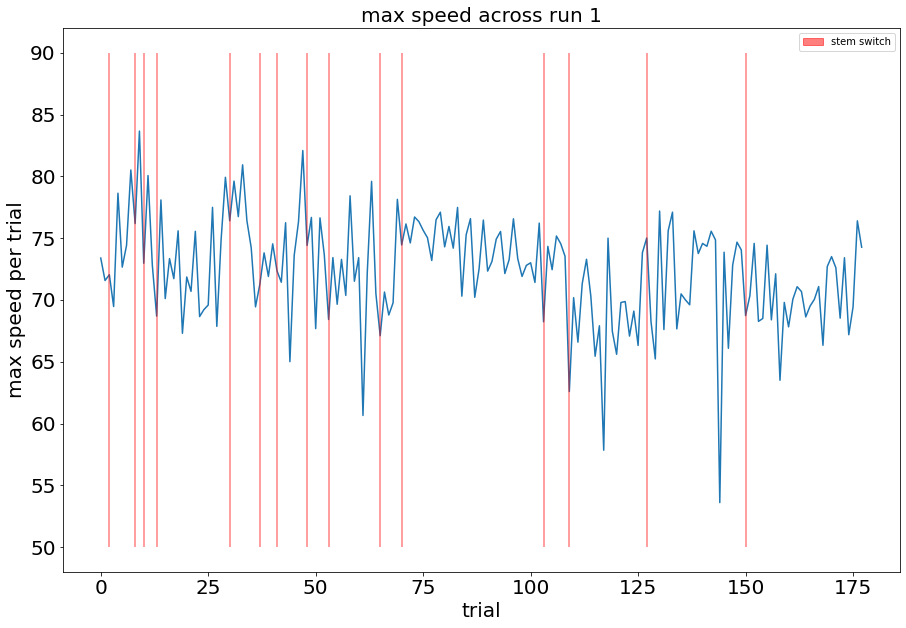

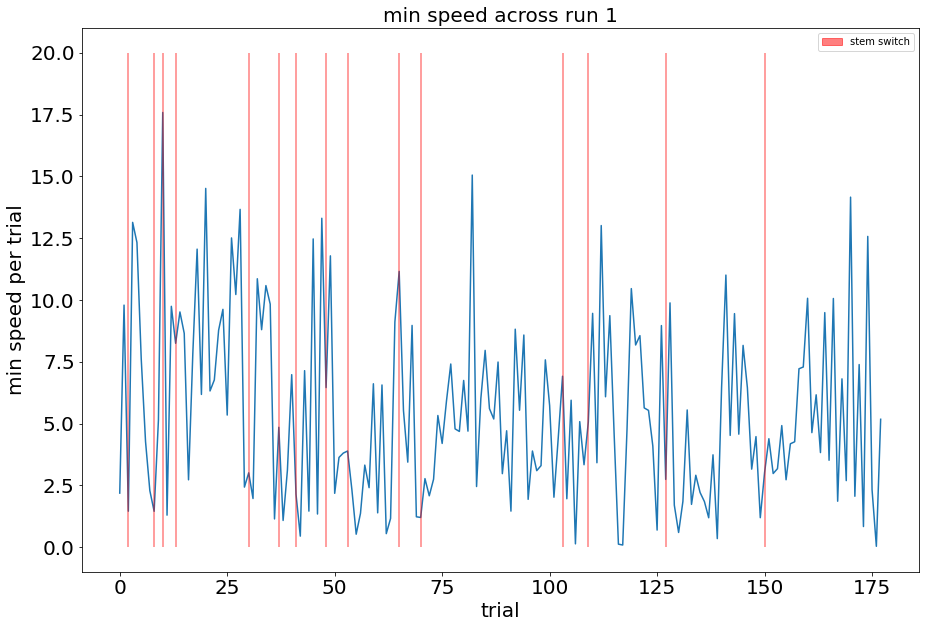

In [671]:
import matplotlib.patches as mpatches


plt.figure(figsize=(15,10))
# plt.scatter(range(len(mean_speed)),mean_speed)
plt.plot(range(len(mean_speed)),mean_speed)
plt.ylabel('mean speed per trial',fontsize=20)
plt.xlabel('trial',fontsize=20)
plt.title('average speed across run 1', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for ix in range(len(stem_switch_trials)): 
    plt.vlines(stem_switch_trials[ix],0,60, color = 'r', alpha=.5)
    plt.text(stem_switch_trials[ix],60, f'{e2.iloc[stem_switch_trials[ix]].stem}')
red_patch = mpatches.Patch(color='r', alpha=.5, label='stem switch')
plt.legend(handles=[red_patch],loc = 'upper right')       

plt.figure(figsize=(15,10))
plt.plot(range(len(max_speed)),max_speed)
plt.ylabel('max speed per trial',fontsize=20)
plt.xlabel('trial',fontsize=20)
plt.title('max speed across run 1', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for ix in range(len(stem_switch_trials)): 
    plt.vlines(stem_switch_trials[ix],50,90, color = 'r', alpha=.5)
red_patch = mpatches.Patch(color='r', alpha=.5, label='stem switch')
plt.legend(handles=[red_patch],loc = 'upper right')       




plt.figure(figsize=(15,10))
plt.plot(range(len(min_speed)),min_speed)
plt.ylabel('min speed per trial',fontsize=20)
plt.xlabel('trial',fontsize=20)
plt.title('min speed across run 1', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for ix in range(len(stem_switch_trials)): 
    plt.vlines(stem_switch_trials[ix],0,20, color = 'r', alpha=.5)
red_patch = mpatches.Patch(color='r', alpha=.5, label='stem switch')
plt.legend(handles=[red_patch],loc = 'upper right')       




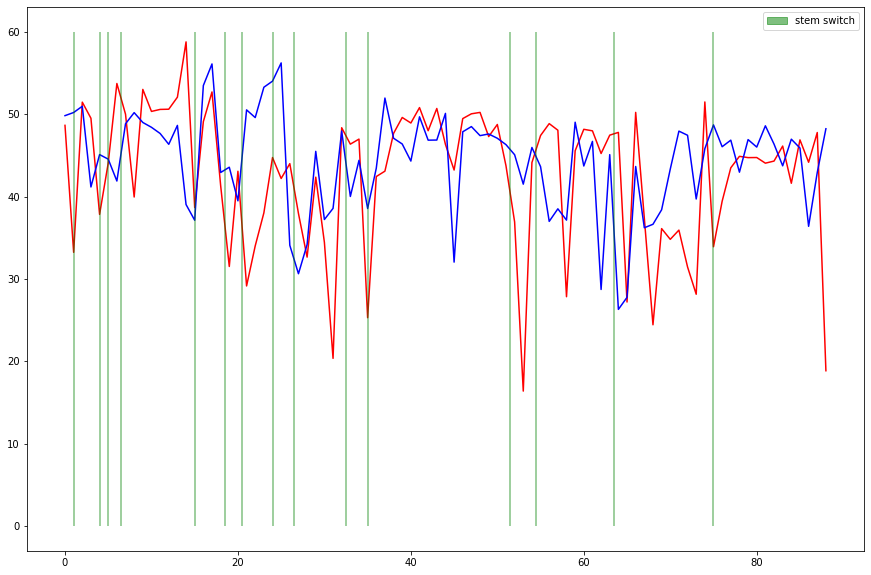

In [672]:
plt.figure(figsize=(15,10))
# plt.scatter(range(len(mean_speed)),mean_speed)

plt.plot(range(int(len(mean_speed[0::2]))),mean_speed[0::2],color='r')
plt.plot(range(int(len(mean_speed[1::2]))),mean_speed[1::2],color='b')
for ix in range(len(stem_switch_trials)): 
    plt.vlines(stem_switch_trials[ix]/2,0,60, color = 'g', alpha=.5)
red_patch = mpatches.Patch(color='g', alpha=.5, label='stem switch')
plt.legend(handles=[red_patch],loc = 'upper right')       

# plt.plot(range(len(mean_speed)),mean_speed)
# plt.ylabel('mean speed per trial',fontsize=20)
# plt.xlabel('trial',fontsize=20)
# plt.title('average speed across run 1', fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)
# for ix in range(len(stem_switch_trials)): 
#     plt.vlines(stem_switch_trials[ix],0,60, color = 'r', alpha=.5)
# red_patch = mpatches.Patch(color='r', alpha=.5, label='stem switch')
# plt.legend(handles=[red_patch],loc = 'upper right')       

In [673]:
stem_switch_trials = (e2[e2.stem_switch == True]).index

In [674]:
(e2[e2.stem_switch == True]).index

Int64Index([2, 8, 10, 13, 30, 37, 41, 48, 53, 65, 70, 103, 109, 127, 150], dtype='int64')

In [675]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,going_tow_better,avg_speed,bout_num,bout_lens_per_bout,delta1_2,delta2_1,delta3_4,delta4_3,delta5_6,delta6_5
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,1,48.655067,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,49.832956,2,6.0,0.534602,-0.534602,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,33.240799,2,6.0,-0.177065,0.177065,NaN,NaN,NaN,NaN
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,50.213815,2,6.0,0.087688,-0.087688,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0,36.396941,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.079630,-0.079630
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,47.783901,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.060240,-0.060240
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,42.932353,16,30.0,0.032151,-0.032151,0.046845,-0.046845,-0.052431,0.052431
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,18.862685,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.045636,-0.045636


In [568]:
# should seperate the one long b bout in the middle. 
#plot his speed vs where hes running to 

In [676]:
e2['bout_num'] = e2['stem'].ne(trial_times['stem'].shift()).cumsum()

In [677]:
e2

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,going_tow_better,avg_speed,bout_num,bout_lens_per_bout,delta1_2,delta2_1,delta3_4,delta4_3,delta5_6,delta6_5
1,senor20201030_.nwb,2,1,3,B,0,1.604078e+09,NaN,NaN,1.604078e+09,...,0,NaN,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,senor20201030_.nwb,2,2,2,A,0,1.604078e+09,NaN,NaN,1.604078e+09,...,1,48.655067,2,6.0,NaN,NaN,NaN,NaN,NaN,NaN
3,senor20201030_.nwb,2,3,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,49.832956,2,6.0,0.534602,-0.534602,NaN,NaN,NaN,NaN
4,senor20201030_.nwb,2,4,2,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,33.240799,2,6.0,-0.177065,0.177065,NaN,NaN,NaN,NaN
5,senor20201030_.nwb,2,5,1,A,1,1.604078e+09,1.604078e+09,1.604078e+09,1.604078e+09,...,1,50.213815,2,6.0,0.087688,-0.087688,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,senor20201030_.nwb,2,175,6,C,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0,36.396941,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.079630,-0.079630
176,senor20201030_.nwb,2,176,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,47.783901,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.060240,-0.060240
177,senor20201030_.nwb,2,177,6,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,42.932353,16,30.0,0.032151,-0.032151,0.046845,-0.046845,-0.052431,0.052431
178,senor20201030_.nwb,2,178,5,C,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,18.862685,16,30.0,0.032151,-0.032151,0.046845,-0.046845,0.045636,-0.045636


In [678]:
#fund the lengths of the bouts
for ix in range(1,e2.bout_num.max()):
    bout_len = len(e2[e2.bout_num==ix])
    print(bout_len)

1
6
2
3
17
7
4
7
5
12
5
33
6
18
23


In [679]:
bout_len_of_interest = 33
for ix in range(1,e2.bout_num.max()):
    bout_len = len(e2[e2.bout_num==ix])
    if bout_len== bout_len_of_interest: 
        bout_of_interest = e2[e2.bout_num==ix]

In [680]:
e2.bout_num.max()

16

In [681]:
bout_of_interest

,nwb_file_name,epoch,trial_number_by_epoch,leaf,stem,reward,poke_in_ts,reward_on_ts,reward_off_ts,poke_out_ts,...,going_tow_better,avg_speed,bout_num,bout_lens_per_bout,delta1_2,delta2_1,delta3_4,delta4_3,delta5_6,delta6_5
70,senor20201030_.nwb,2,70,4,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,46.986556,12,33.0,-0.049072,0.049072,-0.256117,0.256117,0.038216,-0.038216
71,senor20201030_.nwb,2,71,3,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,44.407495,12,33.0,-0.049072,0.049072,0.098956,-0.098956,0.038216,-0.038216
72,senor20201030_.nwb,2,72,4,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,25.302404,12,33.0,-0.049072,0.049072,-0.084018,0.084018,0.038216,-0.038216
73,senor20201030_.nwb,2,73,3,B,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0,38.560711,12,33.0,-0.049072,0.049072,-0.066496,0.066496,0.038216,-0.038216
74,senor20201030_.nwb,2,74,4,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,42.438828,12,33.0,-0.049072,0.049072,-0.080074,0.080074,0.038216,-0.038216
75,senor20201030_.nwb,2,75,3,B,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0,43.44622,12,33.0,-0.049072,0.049072,-0.067285,0.067285,0.038216,-0.038216
76,senor20201030_.nwb,2,76,4,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,43.093307,12,33.0,-0.049072,0.049072,-0.077247,0.077247,0.038216,-0.038216
77,senor20201030_.nwb,2,77,3,B,0,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,0,51.967817,12,33.0,-0.049072,0.049072,-0.067822,0.067822,0.038216,-0.038216
78,senor20201030_.nwb,2,78,4,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,47.681023,12,33.0,-0.049072,0.049072,-0.075192,0.075192,0.038216,-0.038216
79,senor20201030_.nwb,2,79,3,B,1,1.604079e+09,1.604079e+09,1.604079e+09,1.604079e+09,...,1,47.091369,12,33.0,-0.049072,0.049072,0.064873,-0.064873,0.038216,-0.038216


In [682]:
trial_timestamps =[]
for ix in range(len(bout_of_interest)-1):
    trial_start = bout_of_interest.iloc[ix].poke_out_ts
    trial_end =  bout_of_interest.iloc[ix+1].poke_in_ts
    trial_timestamps.append([trial_start,trial_end])
# plt.figure(figsize=(50,15))
mean_speed=[]
max_speed=[]
min_speed=[]
for ix in range(len(trial_timestamps)):
    speed_x,speed_y = get_speed_timestamp(trial_timestamps[ix][0],trial_timestamps[ix][1],position_info)
    mean_speed.append(statistics.mean(speed_y))
    max_speed.append(speed_y.max())
    min_speed.append(speed_y.min())

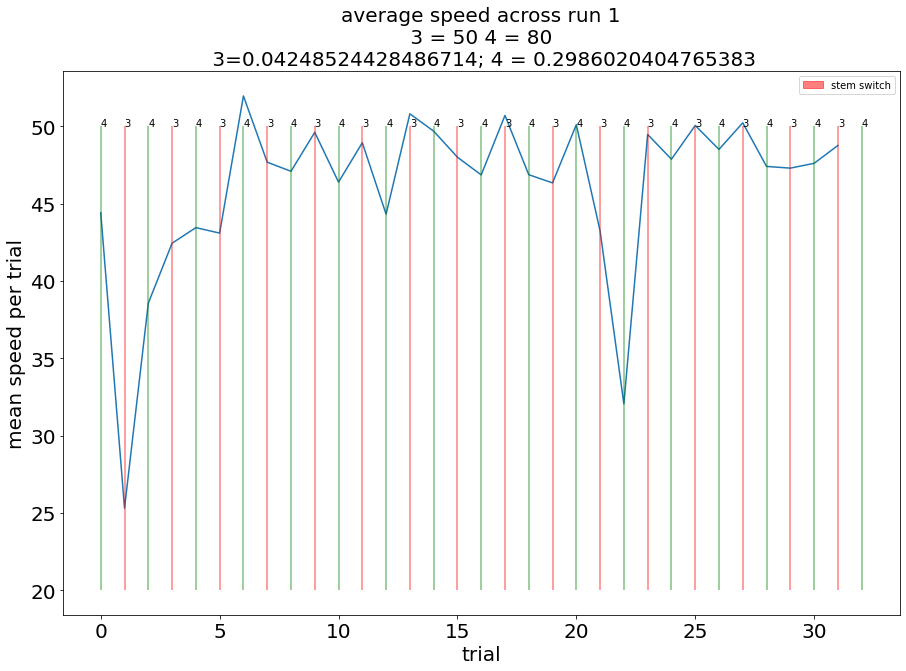

In [687]:
plt.figure(figsize=(15,10))
# plt.scatter(range(len(mean_speed)),mean_speed)
plt.plot(range(len(mean_speed)),mean_speed)
plt.ylabel('mean speed per trial',fontsize=20)
plt.xlabel('trial',fontsize=20)
plt.title(f'average speed across run 1\n 3 = {bout_of_interest.iloc[0].p_rew_leaf3} 4 = {bout_of_interest.iloc[0].p_rew_leaf4} \n 3={bout_of_interest.iloc[0].rew_rate_3  }; 4 = {bout_of_interest.iloc[0].rew_rate_4}', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
for ix in range(len(bout_of_interest)): 
    if bout_of_interest.iloc[ix].leaf == 3:
        plt.vlines(ix,20,50, color = 'r', alpha=.5)
    else: 
        plt.vlines(ix,20,50, color = 'g', alpha=.5)
    plt.text(ix,50, f'{bout_of_interest.iloc[ix].leaf}')


red_patch = mpatches.Patch(color='r', alpha=.5, label='stem switch')
plt.legend(handles=[red_patch],loc = 'upper right')       



In [689]:
bout_of_interest.iloc[-1].rew_rate_3

0.526726200410573

In [690]:
bout_of_interest.iloc[-1].rew_rate_4

0.5880600299760097

In [684]:
bout_of_interest.iloc[0]

nwb_file_name                 senor20201030_.nwb
epoch                                          2
trial_number_by_epoch                         70
leaf                                           4
stem                                           B
reward                                         1
poke_in_ts                     1604078716.000853
reward_on_ts                   1604078716.046853
reward_off_ts                  1604078716.346853
poke_out_ts                    1604078722.846853
contingency_count                              1
trials_thresh_per_conting                     60
minutes_thresh_per_conting                    20
p_rew_leaf1                                   20
p_rew_leaf2                                   50
p_rew_leaf3                                   50
p_rew_leaf4                                   80
p_rew_leaf5                                   20
p_rew_leaf6                                   20
decay_percent                                NaN
p_rew_reset_leaf1   